In [1]:
%matplotlib inline

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

import scanpy as sc

import sys
sys.path.append('/home/ngr4/project')
import scnd.scripts.data as scnddata
import bbknn
import phate

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
adata = scnddata.load_human_redo(imputed=True)

Name this annotation round `v0` because we are still unsure about these annotations or whether we will need to modify the clusters

In [3]:
adata.obs['ctype_v0'] = 'Unassigned'
for i in range(16):
    adata.obs.loc[adata.obs['leiden']==str(i), 'ctype_v0'] = 'Granule cells'
for i in range(17, 21):
    adata.obs.loc[adata.obs['leiden']==str(i), 'ctype_v0'] = 'Granule cells'
for i in range(23, 27):
    adata.obs.loc[adata.obs['leiden']==str(i), 'ctype_v0'] = 'Granule cells'
for i in range(28, 30):
    adata.obs.loc[adata.obs['leiden']==str(i), 'ctype_v0'] = 'Granule cells'
for i in range(31, 34):
    adata.obs.loc[adata.obs['leiden']==str(i), 'ctype_v0'] = 'Granule cells'
adata.obs.loc[adata.obs['leiden']=='35', 'ctype_v0'] = 'Granule cells'
adata.obs.loc[adata.obs['leiden']=='42', 'ctype_v0'] = 'Granule cells'

adata.obs.loc[(adata.obs['leiden']=='21') | (adata.obs['leiden']=='37'), 'ctype_v0'] = 'Subcluster'
adata.obs.loc[(adata.obs['leiden']=='27') | (adata.obs['leiden']=='30'), 'ctype_v0'] = 'Astrocytes'
adata.obs.loc[adata.obs['leiden']=='16', 'ctype_v0'] = 'Bergmann glia'
adata.obs.loc[adata.obs['leiden']=='36', 'ctype_v0'] = 'Subcluster' #'Oligodendrocyte progenitor cells'
adata.obs.loc[(adata.obs['leiden']=='22') | (adata.obs['leiden']=='39') | (adata.obs['leiden']=='40') , 'ctype_v0'] = 'Oligodendrocytes'
adata.obs.loc[(adata.obs['leiden']=='38') | (adata.obs['leiden']=='41'), 'ctype_v0'] = 'Microglia'
adata.obs.loc[adata.obs['leiden']=='34', 'ctype_v0'] = 'Pericytes'

In [4]:

markersoi = [
    'GABRA6', 'SLC17A7', 'SLC17A6', 'EOMES', 
    'ATP2A3', 'CALB1', 'CA8', 'PPP1R17', 'SLC1A6', 
    'GAD1', 'GAD2', 'NTN1', 'MEGF10', 'ALDH1L1', 'AQP4',
    'GDF10', 'HOPX', 'OLIG1', 'OLIG2', 'PDGFRA',
    'HAPLN2', 'MAG', 'MOG', 'OPALIN', 'C1QB', 
    'CX3CR1', 'DOCK2', 'P2RY12', 'FLT1', 'RGS5', 'DCN', 'LUM', 'KDR'
]


... storing 'ctype_v0' as categorical


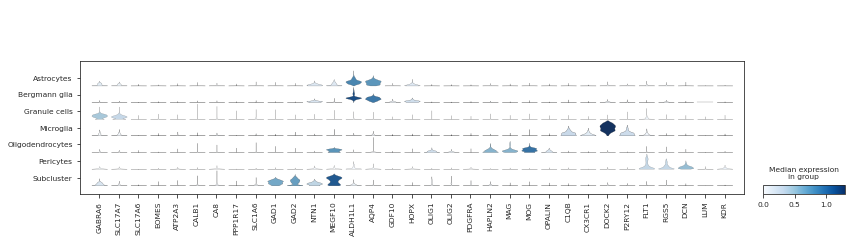

In [5]:
sc.pl.StackedViolin(adata, 
                    markersoi,
                    groupby='ctype_v0', 
                    use_raw=False, 
                    layer='imputed').savefig(
    '/home/ngr4/project/scnd/results/violin_hum_redo_ctypev0_annotation.pdf', 
    bbox_inches='tight', 
    dpi=300
)

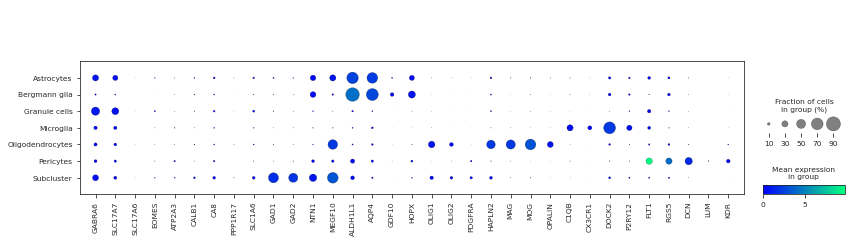

In [6]:
sc.pl.DotPlot(adata, 
                    markersoi,
                    groupby='ctype_v0', 
                    use_raw=True).savefig(
    '/home/ngr4/project/scnd/results/dotplot_hum_redo_ctypev0_annotation.pdf', 
    bbox_inches='tight', 
    dpi=300
)

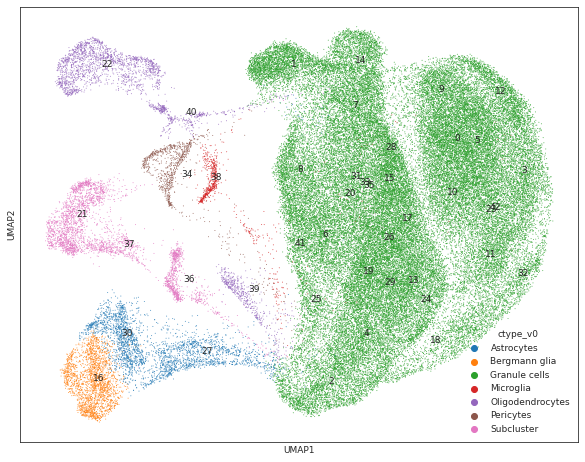

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.scatterplot(x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                hue=adata.obs['ctype_v0'],
                linewidth=0,
                alpha=0.8,
                s=1,
                rasterized=True,
                ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

for l in adata.obs['leiden'].unique():
    x, y = np.mean(adata[adata.obs['leiden']==l, :].obsm['X_umap'], 0)
    ax.text(x, y, l)
    
fig.savefig('/home/ngr4/project/scnd/results/umap_hum_redo_leiden_ctypev0_annotation.pdf', bbox_inches='tight', dpi=600)

# subclustering

27+31 leiden clusters are likely a composite of cell types. These clusters are taken for further subclustering

In [36]:
def subcluster(tdata, markersoi, resolution=2.0, plotfp=None, short_name=None):
    def graph_pp(AnnData, use_bbknn=True, k=3, n_pcs=20):
        sc.tl.pca(AnnData, n_comps=n_pcs)
        if use_bbknn:
            bbknn.bbknn(AnnData,
                        n_pcs=n_pcs,
                        neighbors_within_batch=k) 
        else:
            sc.pp.neighbors(AnnData, n_pcs=n_pcs, n_neighbors=k)
        return AnnData
    tdata = graph_pp(tdata)
    sc.tl.umap(tdata)
    sc.tl.leiden(tdata, resolution=resolution)
    
    # save visualizations
    if plotfp is not None:
        
        if short_name is None:
            short_name = 'subclustering'
            
        # plot 1
        sc.pl.StackedViolin(tdata, 
                    markersoi,
                    groupby='leiden', 
                    use_raw=False, 
                    layer='imputed').savefig(
            os.path.join(plotfp, 'violin_hum_redo_{}.pdf'.format(short_name)),
        bbox_inches='tight', 
        dpi=300)
        
        # plot 2
        sc.pl.DotPlot(tdata, 
                    markersoi,
                    groupby='leiden', 
                    use_raw=True).savefig(
            os.path.join(plotfp, 'dot_hum_redo_{}.pdf'.format(short_name)), 
        bbox_inches='tight', 
        dpi=300)
        
        # plot 3
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        sns.scatterplot(x=tdata.obsm['X_umap'][:, 0],
                        y=tdata.obsm['X_umap'][:, 1],
                        hue=tdata.obs['leiden'],
                        linewidth=0,
                        alpha=0.8,
                        s=1,
                        rasterized=True,
                        ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        for l in tdata.obs['leiden'].unique():
            x, y = np.mean(tdata[tdata.obs['leiden']==l, :].obsm['X_umap'], 0)
            ax.text(x, y, l)
        fig.savefig(os.path.join(plotfp, 'umap_hum_redo_{}.pdf'.format(short_name)), bbox_inches='tight', dpi=600)
    return tdata

In [14]:

markers = [
    'GABRA6', 'SLC17A7', 'SLC17A6', 'EOMES', 
    'ATP2A3', 'CALB1', 'CA8', 'PPP1R17', 'SLC1A6', 
    'GAD1', 'GAD2', 'NTN1', 'MEGF10', 'ALDH1L1', 'AQP4',
    'GDF10', 'HOPX', 'OLIG1', 'OLIG2', 'PDGFRA',
    'HAPLN2', 'MAG', 'MOG', 'OPALIN', 'C1QB', 
    'CX3CR1', 'DOCK2', 'P2RY12', 'FLT1', 'RGS5', 'DCN', 'LUM', 'KDR',
    'LYPD6', 'SORCS3', 'PTPRK', 'NXPH1', 'CDH22',
]


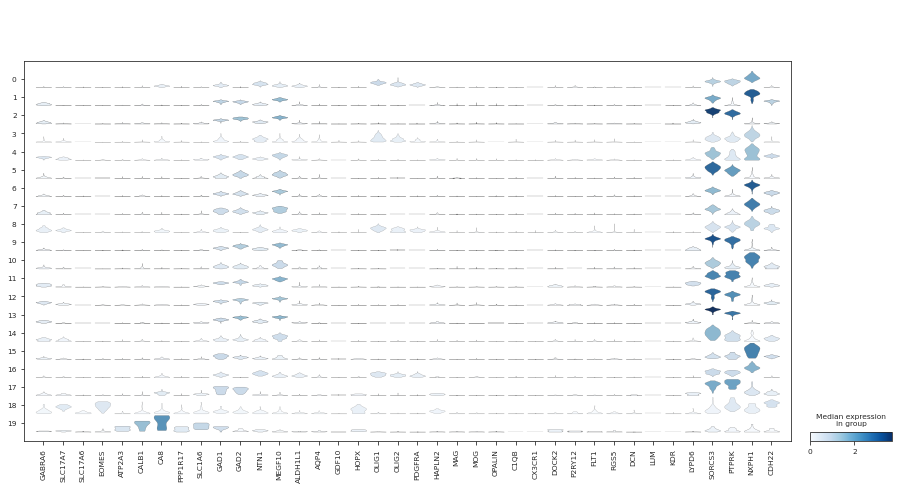

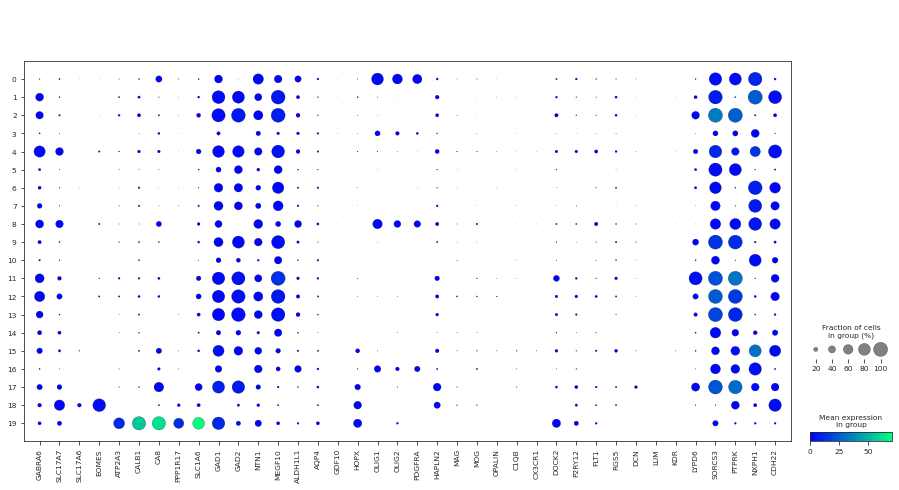

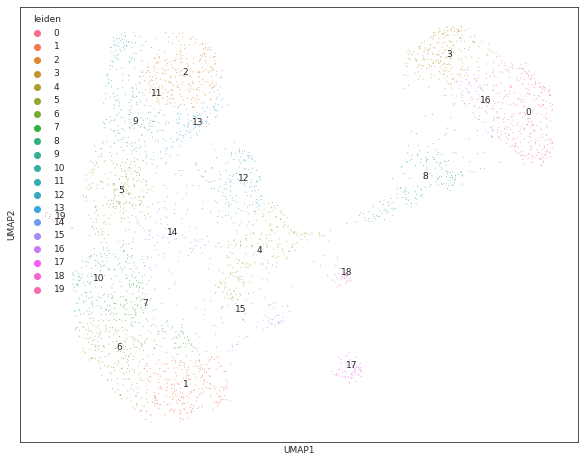

In [15]:
tdata = subcluster(adata[(adata.obs['ctype_v0']=='Subcluster'), :], markers, plotfp='/home/ngr4/project/scnd/results')

## intermediate assignment

assign some clusters, then re-cluster

In [24]:
adata.obs['ctype_v1'] = adata.obs['ctype_v0'].astype(str)
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[(tdata.obs['leiden'] == '0') | (tdata.obs['leiden'] == '3') | 
              (tdata.obs['leiden'] == '8') | (tdata.obs['leiden'] == '16'), :].index.to_list()), 'ctype_v1'] = 'Oligodendrocyte progenitor cells'
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[(tdata.obs['leiden'] == '18'), :].index.to_list()), 'ctype_v1'] = 'Unipolar brush cells'
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[(tdata.obs['leiden'] == '19'), :].index.to_list()), 'ctype_v1'] = 'Purkinje cells'

... storing 'ctype_v1' as categorical


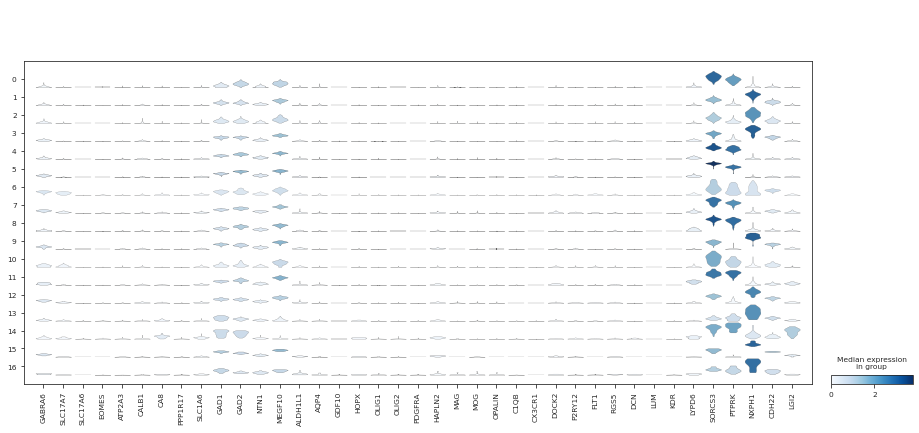

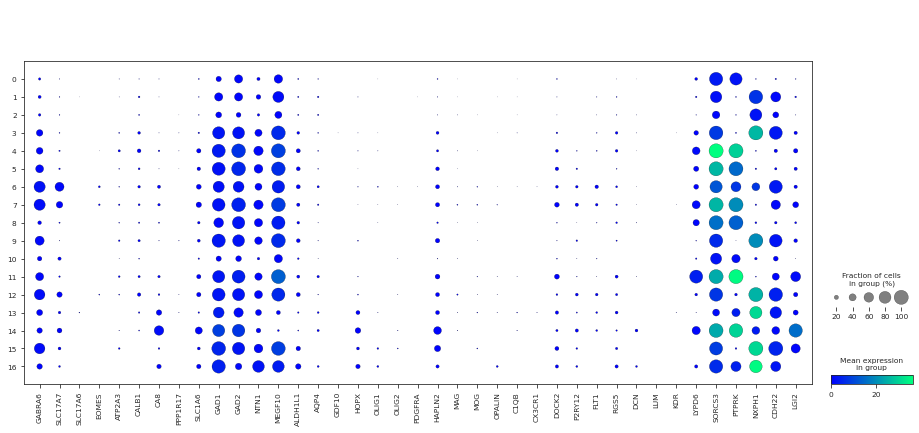

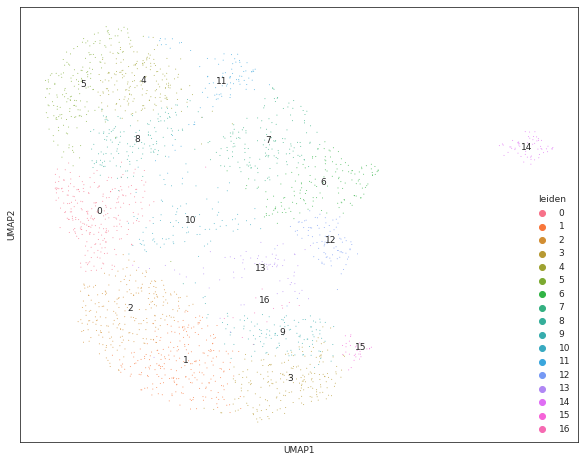

In [26]:

markers = [
    'GABRA6', 'SLC17A7', 'SLC17A6', 'EOMES', 
    'ATP2A3', 'CALB1', 'CA8', 'PPP1R17', 'SLC1A6', 
    'GAD1', 'GAD2', 'NTN1', 'MEGF10', 'ALDH1L1', 'AQP4',
    'GDF10', 'HOPX', 'OLIG1', 'OLIG2', 'PDGFRA',
    'HAPLN2', 'MAG', 'MOG', 'OPALIN', 'C1QB', 
    'CX3CR1', 'DOCK2', 'P2RY12', 'FLT1', 'RGS5', 'DCN', 'LUM', 'KDR',
    'LYPD6', 'SORCS3', 'PTPRK', 'NXPH1', 'CDH22', 'LGI2',
]

tdata = subcluster(adata[(adata.obs['ctype_v1']=='Subcluster'), :], markers, plotfp='/home/ngr4/project/scnd/results', short_name='subclustering2')

In [28]:
adata.obs['ctype'] = adata.obs['ctype_v1'].astype(str)
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[tdata.obs['leiden'].isin([str(i) for i in [0,4,5,6,7,8,10,11]]), :].index.to_list()), 'ctype'] = 'IN1 (MLI1)'
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[tdata.obs['leiden'].isin([str(i) for i in [1,2,3,9,12,13,15,16]]), :].index.to_list()), 'ctype'] = 'IN2 (MLI2)'
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[(tdata.obs['leiden'] == '14'), :].index.to_list()), 'ctype'] = 'IN3 (GoC)'

In [30]:
# save adata
scnddata.save_adata(adata, '/home/ngr4/project/scnd/data/processed/hum_imp_211006.h5ad')

AnnData object with n_obs × n_vars = 79928 × 28971
    obs: 'batch', 'Sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'source', 'ctype_v0', 'ctype_v1', 'ctype'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    layers: 'imputed'

adata saved @211006.15:54:40


In [32]:
def ctype_plots(tdata, markersoi, plotfp=None, short_name=None, groupby='ctype'):
    # plot 1
    sc.pl.StackedViolin(tdata, 
                markersoi,
                groupby=groupby, 
                use_raw=False, 
                layer='imputed').savefig(
        os.path.join(plotfp, 'violin_hum_redo_{}.pdf'.format(short_name)),
    bbox_inches='tight', 
    dpi=300)

    # plot 2
    sc.pl.DotPlot(tdata, 
                markersoi,
                groupby=groupby, 
                use_raw=True).savefig(
        os.path.join(plotfp, 'dot_hum_redo_{}.pdf'.format(short_name)), 
    bbox_inches='tight', 
    dpi=300)

    # plot 3
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    sns.scatterplot(x=tdata.obsm['X_umap'][:, 0],
                    y=tdata.obsm['X_umap'][:, 1],
                    hue=tdata.obs[groupby],
                    linewidth=0,
                    alpha=0.8,
                    s=1,
                    rasterized=True,
                    ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    for l in tdata.obs[groupby].unique():
        x, y = np.mean(tdata[tdata.obs[groupby]==l, :].obsm['X_umap'], 0)
        ax.text(x, y, l)
    fig.savefig(os.path.join(plotfp, 'umap_hum_redo_{}.pdf'.format(short_name)), bbox_inches='tight', dpi=600)

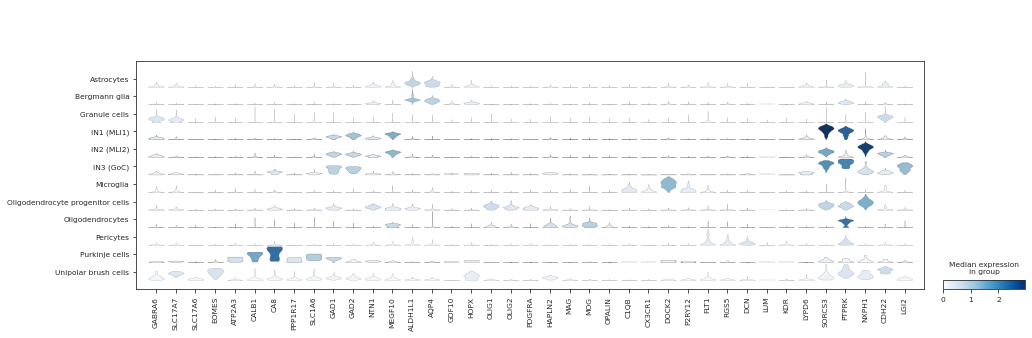

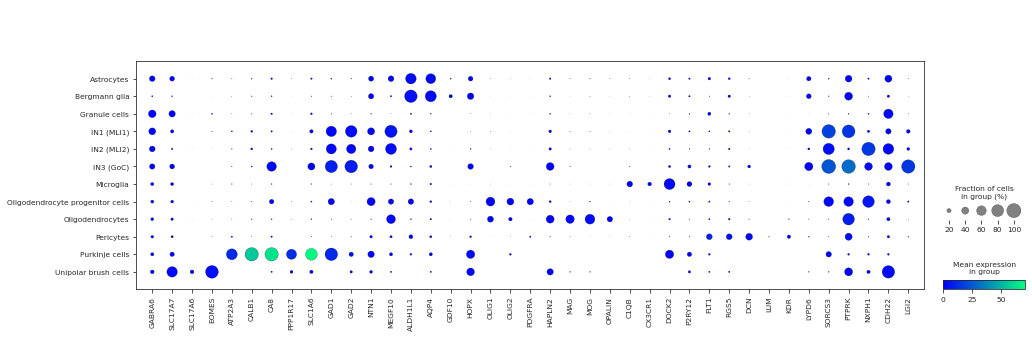

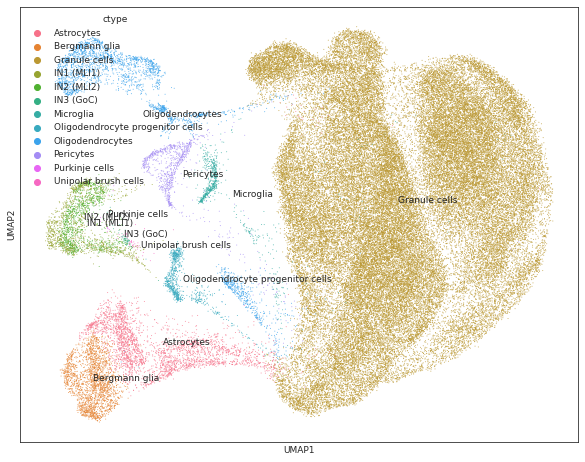

In [34]:
ctype_plots(adata, markers, plotfp='/home/ngr4/project/scnd/results/', short_name='ctype')

## addtl assignments

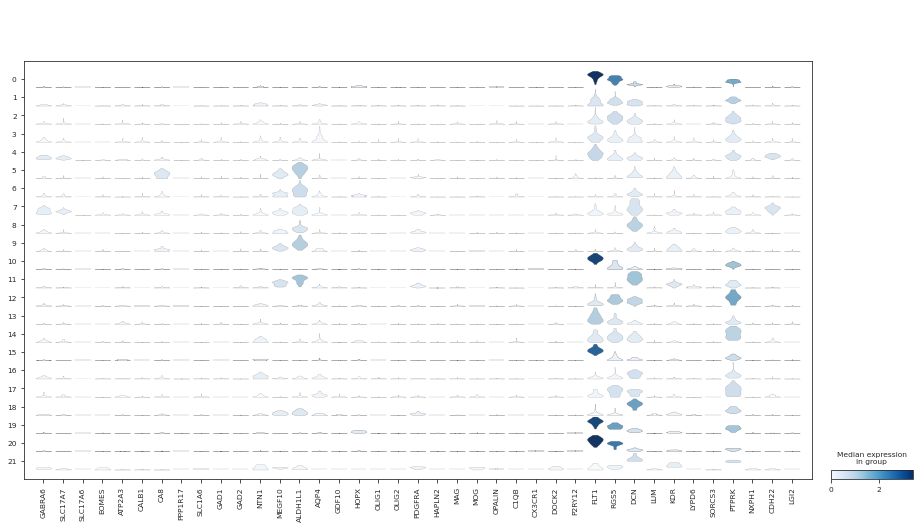

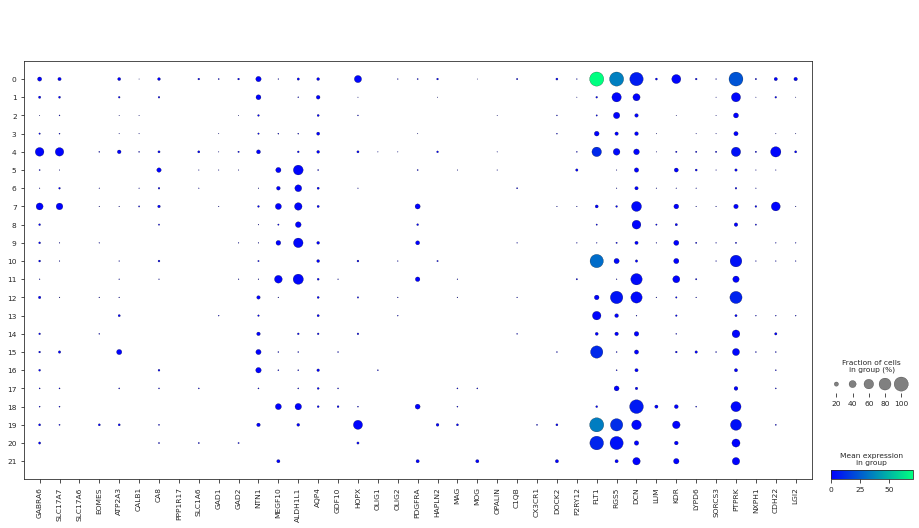

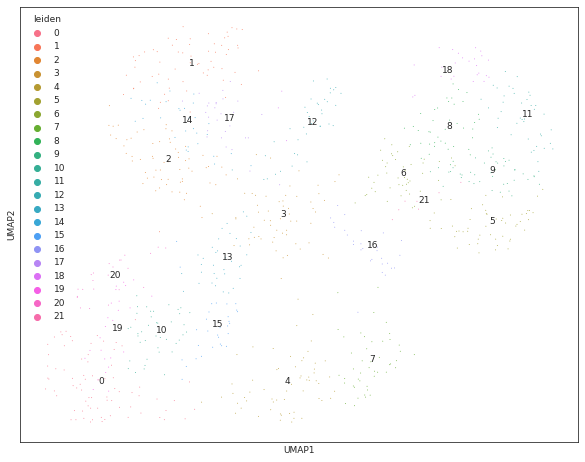

In [37]:
tdata = subcluster(adata[(adata.obs['ctype']=='Pericytes'), :], markers, plotfp='/home/ngr4/project/scnd/results', short_name='Pericytes', resolution=3.0)

In [38]:
adata.obs['ctype'] = adata.obs['ctype'].astype(str)
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[tdata.obs['leiden'].isin([str(i) for i in [0,1,2,3,4,7,10,11,12,13,14,15,16,17,18,19,20]]), :].index.to_list()), 'ctype'] = 'Pericytes'
adata.obs.loc[adata.obs.index.isin(tdata.obs.loc[tdata.obs['leiden'].isin([str(i) for i in [5,6,8,9,11,21]]), :].index.to_list()), 'ctype'] = 'Endothelial cells'


In [39]:
# save adata
scnddata.save_adata(adata, '/home/ngr4/project/scnd/data/processed/hum_imp_211006.h5ad')

... storing 'ctype' as categorical


AnnData object with n_obs × n_vars = 79928 × 28971
    obs: 'batch', 'Sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'source', 'ctype_v0', 'ctype_v1', 'ctype'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    layers: 'imputed'

adata saved @211006.16:32:49


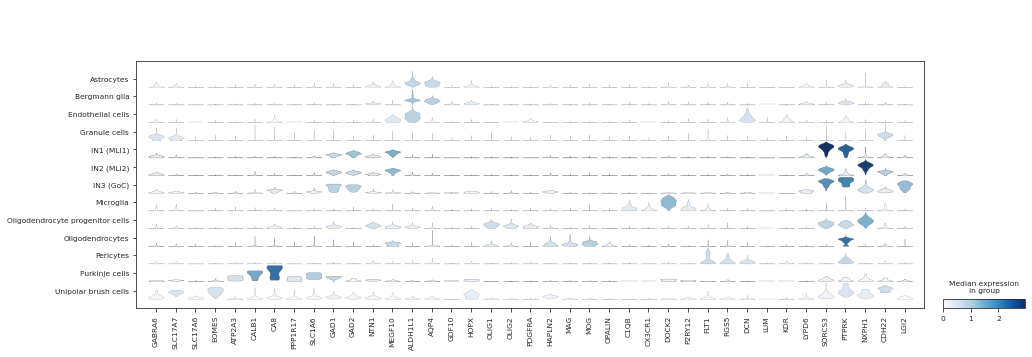

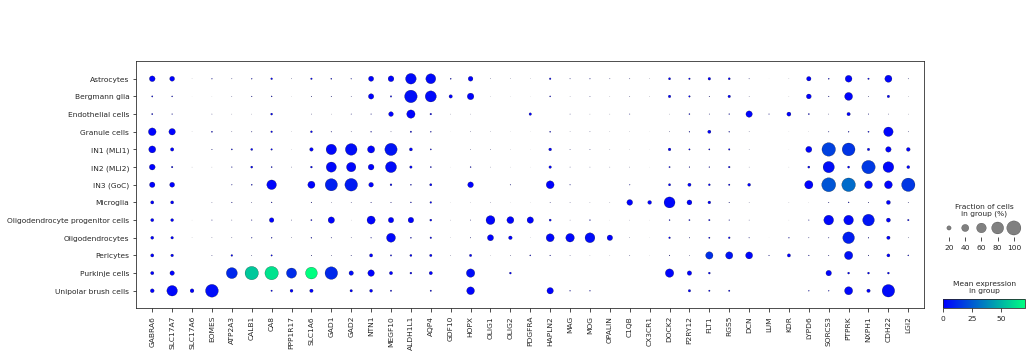

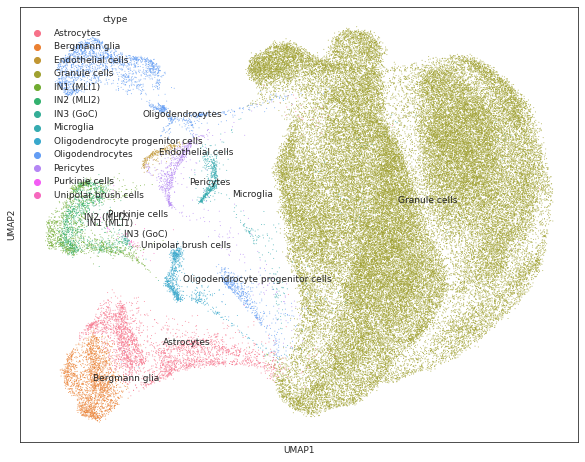

In [40]:
ctype_plots(adata, markers, plotfp='/home/ngr4/project/scnd/results/', short_name='ctype')